<div class="alert alert-warning">
이 노트북을 처음 열어보면 아마도 그림이나 표의 수식 등이 제대로 표시되지 않고 있을 것입니다. 이때는 오른쪽 상단의 "Not Trusted"버튼을 눌러서 나오는 안내창의 "Trust"를 선택해주세요. 노트북에 저장되어 있던 결과들이 제대로 표시될 것입니다. Jupyter Notebook이 아닌 Jupyter Lab 환경이라면 상단 "View" 메뉴의 "Activate Command Palette" 항목을 선택한 다음 "Trust Notebook"이라는 기능을 검색하여 실행하면 됩니다. 검색을 할 때에는 앞 글자 "tr"만 입력하여도 해당 항목이 나옵니다.
</div>

<div class="alert alert-info">
이 노트북은 수강생의 실습을 위해 일부 코드가 누락되어 있습니다. 코드 중간에 주석처리된 부분(`#= .. =#`)이 보인다면 해당 부분에 맞는 코드를 직접 입력해주세요. 질문이 있는 경우, 직접 말씀해주시거나 채팅으로 알려주시면 도와드릴 수 있도록 하겠습니다.
</div>

# 2. 광합성

지난 시간에는 식물의 성장을 logistic, exponential, Gompertz 등 간단한 성장 곡선 모형으로 모의해보았습니다. 이번 시간에는 실제 식물이 어떻게 그러한 곡선의 형태로 성장을 할 수 있는지 조금 더 고민해보면서 특히 광합성을 표현하는 방법에 대해 살펴보겠습니다. 다른 기작들과 마찬가지로 광합성 역시 그 구현 방식에 따라 상대적으로 단순한 모형에서 부터 꽤나 복잡한 기체교환 모형까지 다양하게 생각해볼 수 있습니다. 하지만 작물모형 관점에서는 결국 성장량 변화($\frac{dW}{dt}$)를 표현하는 방식의 차이일뿐이며 기본적으로는 시간에 따라 생체량($W$)이 누적되어 수량이 결정된다는 기본 가정을 계속 가지고 간다는 점을 기억해주세요.

In [1]:
using Cropbox

WebIO._IJuliaInit()

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

## 2.1. 복습

식물이 지수적 성장을 계속할 수는 없기 때문에 언젠가 성장이 둔화되는 상황을 표현해야 하는데요. Logistic 모형에서는 주어진 최종 생체량(`Wf`)에 따라 S자 형태로 성장이 둔화되도록 처리하여 해결하고자 하였습니다. 이와는 달리 Gompertz 모형에서는 성장률(`r`)이 시간에 따른 성장 효율 저하도(`α`)에 따라 감소하는 접근 방식을 택하고 있었습니다.

$$
\begin{align}
\frac{dW}{dt} &= r_t W_t \\
\frac{dr}{dt} &= -\alpha r_t \\
W_{t = 0} &= W_0 \\
r_{t = 0} &= r_0
\end{align}
$$

| 이름 | 값 | 단위 | 설명 |
| :- | :- | :- | :- |
| $\alpha$ | 0.005 | $\mathrm{d^{-1}}$ | 시간에 따른 성장 효율 저하도 |
| $r_0$ | 0.05 | $\mathrm{g}\ \mathrm{g^{-1}}\ \mathrm{d^{-1}}$ | 효율 저하 이전의 초기 최적 성장률 |
| $r$ | - | $$\mathrm{g}\ \mathrm{g^{-1}}\ \mathrm{d^{-1}}$$ | 상대성장률 |
| $$W_0$$ | 0.25 | $\mathrm{g}$ | 최초 생체량 |
| $W$ | - | $\mathrm{g}$ | 시간별 생체량 |
| $t$ | - | $\mathrm{d}$ | 시간 |

이쯤에서 지난 시간의 기억을 되살려 Gompertz 모형을 Cropbox 기반으로 다시 한번 만들어보겠습니다. 아래 모형 명세의 빈 부분(`#= .. =#`)에 해당하는 코드를 넣어주세요. 혹시 질문이 있다면 조교에게 도움을 요청하시면 됩니다.

In [3]:
@system Gompertz(Controller) begin
    α:  decay_rate          ~ preserve(parameter, u"d^-1")
    r0: initial_growth_rate ~ preserve(parameter, u"g/g/d")
    W0: initial_biomass     ~ #= ..=#(#= ..=#, u"g")

    r(r, α): growth_rate => (-α * r) ~ accumulate(init = r0, u"g/g/d")
    W(W, r): biomass     => #= ..=#  ~ #= ..=#(init = #= ..=#, #= ..=#)

    t(context.clock.time): time ~ track(u"d")
end

Gompertz

코드가 올바로 만들어졌다면 이제 모수에 따라 움직이는 그래프를 그려서 Gompertz 모형이 실제 어떤 식으로 작동하는지 살펴보겠습니다.

In [4]:
manipulate(Gompertz, :t, :W;
    parameters = :Gompertz => (;
        α  = 0:0.001:0.02,
        r0 = 0:0.01:0.1,
        W0 = 0.1:0.01:1,
    ),
    stop = 300u"d",
    kind = :line,
    ylim = (0, 400),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Gompertz"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["α"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 21, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
11, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000170b85ee0, Task (runnable) @0x0000000170b85ee0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                con

여기서 눈여겨보아야 할 것은 성장률(`r`)입니다. 성장 효율 저하도(`α`)에 따라 감소하도록 되어 있는 이 성장률은 실제 식물 성장에서 어떤 의미가 있는 것일까요?

In [5]:
manipulate(Gompertz, :t, :r;
    config = :Gompertz => (;
        W0 = 0.25,
    ),
    parameters = :Gompertz => (;
        α  = 0:0.001:0.02,
        r0 = 0:0.01:0.1,
    ),
    stop = 300u"d",
    kind = :line,
    ylim = (0, 0.1),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Gompertz"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["α"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 21, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
11, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000174932dc0, Task (runnable) @0x0000000174932dc0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                con

## 2.2. 성장률(`r`) 분해

식물 성장에 중요한 영향을 미치는 생리적 현상에는 먼저 광합성과 호흡을 생각해볼 수 있습니다. 광합성(photosynthesis)은 대기중의 이산화탄소($\mathrm{CO_2}$)을 흡수하여 탄수화물(carbohydrate)를 만들어냅니다. 이렇게 만들어진 탄수화물은 호흡(respiration)을 통해 분해되어 식물체를 유지하기 위한 에너지로 쓰이거나, 새로운 생체량을 만들어내는데 사용됩니다. 이때 전자를 유지호흡(maintenance respiration), 후자를 성장호흡(growth respiration)이라고 구분하는데요. 지금까지 여러가지 성장 곡선으로 표현하고자 하였던 것이 바로 이 성장호흡 부분 되겠습니다.

### 2.2.1. 광합성(`A`)과 호흡(`R`) 분리

식물이 성장하기 위해 필요한 기질(substrate)은 광합성을 통해 생성되고, 이중에서 현상유지를 위해 필요한 만큼 유지호흡으로 먼저 사용된다고 가정하면, 그 나머지가 실제 성장을 위해 사용될 것입니다. 이때 광합성 산물인 탄수화물이 100% 그대로 식물의 구조로 변환될 수는 없기 때문에 변환효율을 고려하도록 하겠습니다. 그 결과, 성장률(`r`)은 아래와 같이 광합성(`A`)과 호흡(`R`)의 차이, 그리고 그 변환효율(`c`)로 표현할 수 있습니다. 여기서는 수식을 많이 단순화하였지만 보다 자세한 내용이 궁금하시다면 [Thornley (1970)](https://doi.org/10.1038/227304b0)를 참고해보세요.

$$
r = c \cdot (A - R)
$$

| 이름 &nbsp;&nbsp;&nbsp;&nbsp; | 값 | 단위 | 설명 |
| :- | :- | :- | :- |
| $c$ | - | | 기질 변환효율 |
| $A$ | 0.4 | $$\mathrm{g}\ \mathrm{g^{-1}}\ \mathrm{d^{-1}}$$ | 탄수화물 등 기질 생산률 |
| $R$ | 0.015 | $\mathrm{g}\ \mathrm{g^{-1}}\ \mathrm{d^{-1}}$ | 유지호흡률 |

여기서 변환효율은 조금 더 자세히 표현해보도록 하겠습니다. 성장을 통해 새로 만들어지는 구조물을 만들기 위한 재료는 결국 광합성 산물인 탄수화물($\mathrm{CH_2O}$)에서 유래하게 되는데요. 이 구조물의 상당 부분이 탄소($\mathrm{C}$)로 구성되어 있다고 가정할 때 1만큼의 탄수화물이 얼마만큼의 생체량으로 변환되는지 그 비율($c_0$)을 생각해볼 수 있습니다. 또한 위에서 언급했던 것처럼 변환 과정 자체의 효율($Y$)을 고려하여 실제 변환비율($c$)은 아래와 같이 정의하겠습니다.

$$
c = Y c_0
$$

| 이름 | 값 | 단위 | 설명 |
| :- | :- | :- | :- |
| $Y$ | 0.75 | - | 생체량 변환 과정의 효율 |
| $c_0$ | 0.889 | - | 생체량의 45%가 탄수화물($\mathrm{CH_2O}$)의 탄소($\mathrm{C}$)에서 유래한다고 가정할 때의 변환비율 ($\frac{\frac{12\ \mathrm{g}\ \mathrm{mol^{-1}}}{30\ \mathrm{g}\ \mathrm{mol^{-1}}}}{0.45}$) |

이제 위의 수식을 모형 명세로 표현해보겠습니다. 우선 생체량(`W`) 관련 변수들은 이전과 동일한 형태로 들어갑니다.

$$
\begin{align}
\frac{dW}{dt} &= r W_t \\
W_{t = 0} &= W_0
\end{align}
$$

| 이름 | 값 | 단위 | 설명 |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | 시간 |
| $r$ | - | $$\mathrm{g}\ \mathrm{g^{-1}}\ \mathrm{d^{-1}}$$ | 상대성장률 |
| $$W_0$$ | 0.25 | $\mathrm{g}$ | 최초 생체량 |
| $W$ | - | $\mathrm{g}$ | 시간별 생체량 |

새로 추가되는 부분은 상대성장률(`r`)을 광합성(`A`)과 호흡(`R`), 그리고 변환효율(`c`) 관련 변수들입니다.

In [6]:
@system Growth0(Controller) begin
    t(context.clock.time) ~ track(u"d")

    W0:         initial_biomass             => 0.25        ~ preserve(parameter, u"g")
    W(r, W):    biomass                     => r * W       ~ accumulate(init = W0, u"g")

    Y:          growth_yield                => 0.75        ~ preserve(parameter)
    c0:         potential_conversion_factor => 0.889       ~ preserve(parameter)
    c(c0, Y):   conversion_factor           => #= ..=#     ~ track

    A:          assimilation_rate           => 0.4         ~ preserve(parameter, u"g/g/d")
    R:          respiration_rate            => 0.015       ~ preserve(parameter, u"g/g/d")

    r(c, A, R): growth_rate                 => #= ..=#     ~ track(u"g/g/d")
end

Growth0

변수들간의 관계도를 `Cropbox.dependency()` 함수를 이용해 그려보겠습니다. 이 관계도를 통해 각 변수들이 서로 어떻게 관련되어 있는지 확인해볼 수 있습니다. 예를 들어 생장률(`r`)은 광합성(`A`), 호흡(`R`), 변환비율(`c`)에 기반하여 계산된다는 것을 화살표의 연결 방향으로 알 수 있습니다.

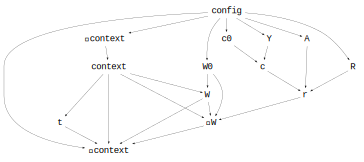

In [7]:
Cropbox.dependency(Growth0)

방금 만든 시스템에 정의되어 있는 모수들을 확인하기 위해 `parameters()` 함수를 호출하면 해당 값들이 담긴 설정(configuration)을 만들어낼 수 있습니다.

In [8]:
parameters(Growth0)

Config for 1 system:
  Growth0
    W0 = 0.25 g
    Y  = 0.75
    c0 = 0.889
    A  = 0.4 d⁻¹
    R  = 0.015 d⁻¹

그럼 이제 모의를 수행해보겠습니다. `simulate()`로 모의를 따로 진행하지 않고, `visualize()` 함수를 이용하여 모의를 수행하여 그대로 그래프를 그려보았습니다. 300일간의 생체량(`W`) 변화입니다.

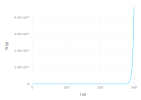

In [9]:
visualize(Growth0, :t, :W;
    stop = 300u"d",
    kind = :line,
)

지난 시간에 보았던 지수적(exponential) 성장곡선처럼 비현실적인 증가를 보이고 있습니다. 상대성장률(`r`)이 항상 같은 값으로 고정되어 있기 때문에 끝없이 성장을 하기 때문입니다. 그래프로 확인해보겠습니다.

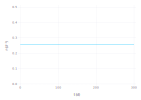

In [10]:
visualize(Growth0, :t, :r;
    stop = 300u"d",
    kind = :line,
    ylim = (0, 0.5),
)

### 2.2.2. 성장 저하 1안 - 변환효율 (`Y`)

그럼 이제 모형을 조금씩 수정하며 보다 현실적으로 만들어보겠습니다. 시간에 따라 성장률(`r`)이 감소하도록 앞서 복습했던 Gompertz 모형의 효율 저하도(decay rate) 개념을 도입해보겠습니다.

$$r = c \cdot (A - R)$$

성장률(`r`)은 좌측의 변환비율(`c`)과 우측의 광합성(`A`), 호흡(`R`) 차이의 두 부분으로 구성되는데요. 이중에서 먼저 변환비율(`c`)에 효율 저하도(`α`)를 적용해보겠습니다.

$$
\begin{align}
\frac{dY}{dt} &= -\alpha Y_t \\
Y_{t = 0} &= Y_0
\end{align}
$$

| 이름 | 값 | 단위 &nbsp; | 설명 |
| :- | :- | :- | :- |
| $\alpha$ | 0.03 | $\mathrm{d^{-1}}$ | 시간에 따른 성장 효율 저하도 |
| $Y_0$ | 0.75 | - | 효율 저하 이전의 최적 변환효율 |
| $Y$ | - | - | 시간에 따라 저하되는 실제 생체량 변환효율 |

In [11]:
@system Growth1(Growth0, Controller) begin
    α:          decary_rate                 => 0.03        ~ preserve(parameter, u"d^-1")
    Y0:         potential_growth_yield      => 0.75        ~ preserve(parameter)
    Y(α, Y):    growth_yield                => #= ..=#     ~ accumulate(init = #= ..=#)
end

Growth1

변환효율(`Y`)가 이제는 더 이상 고정된 모수가 아니라 매번 갱신되는 상태변수로 바뀌었습니다. 대신 효율 저하도(`α`)와 최적 변환효율(`Y0`)이 새로운 모수로 들어갔습니다.

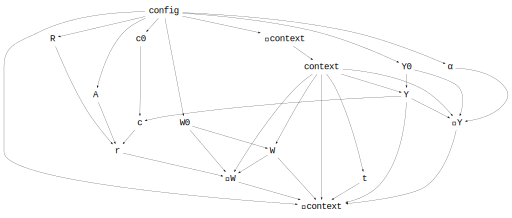

In [12]:
Cropbox.dependency(Growth1)

이제 생체량(`W`) 변화가 앞선 보았던 Gompertz 성장곡선과 유사한 형태가 되었습니다.

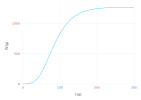

In [13]:
visualize(Growth1, :t, :W;
    stop = 300u"d",
    kind = :line,
)

성장률(`r`)이 시간에 따라 아래와 같이 감소하기 때문입니다.

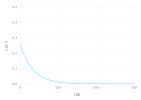

In [14]:
visualize(Growth1, :t, :r;
    stop = 300u"d",
    kind = :line,
    ylim = (0, 0.5),
)

직접적으로는 변환효율(`Y`)이 감소하는 영향이 그대로 반영되고 있기 때문입니다.

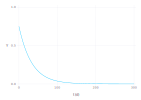

In [15]:
visualize(Growth1, :t, :Y;
    stop = 300u"d",
    kind = :line,
)

대신 광합성(`A`)과 호흡(`R`)에는 아무런 변화가 없습니다. 과연 식물 성장에 따라 단위 생체량 기준 광합성과 호흡량에 아무런 변화가 없는 것은 괜찮을까요?

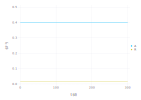

In [16]:
visualize(Growth1, :t, [:A, :R];
    stop = 300u"d",
    kind = :line,
    ylim = (0, 0.5),
)

### 2.2.3. 성장 저하 2안 - 광합성(`A`)과 호흡(`R`)

이번에는 변환효율(`Y`) 대신 광합성(`A`)과 호흡(`R`) 자체의 효율이 시간에 따라 감소한다고 가정해보겠습니다. 앞에서와 동일하게 효율 저하도(`α`)를 추가해보세요. 참고로 `α`(a가 아닌 알파)를 입력하려면 `\alpha`라고 친 다음 탭(tab)키를 누르시면 됩니다.

In [17]:
@system Growth2(Growth0, Controller) begin
    α:          decary_rate                 => 0.03        ~ preserve(parameter, u"d^-1")

    Amax:       maximum_assimilation_rate   => 0.4         ~ preserve(parameter, u"g/g/d")
    Rmax:       maximum_respiration_rate    => 0.015       ~ preserve(parameter, u"g/g/d")

    A(α, A):    assimilation_rate           => -α * A      ~ accumulate(init = Amax, u"g/g/d")
    R(#= ..=#):    respiration_rate            => #= ..=#     ~ accumulate(init = #= ..=#, u"g/g/d")
end

Growth2

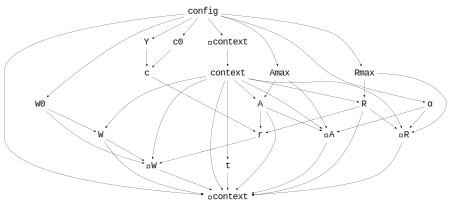

In [18]:
Cropbox.dependency(Growth2)

이제 생체량(`W`) 변화를 확인해보겠습니다. 내부적으로는 다른 가정으로 접근하였지만 전반적인 변화의 양상은 동일하게 나오고 있습니다.

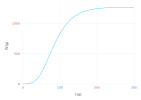

In [19]:
visualize(Growth2, :t, :W;
    stop = 300u"d",
    kind = :line,
)

마찬가지로 성장률(`r`)의 감소 역시 확인해보겠습니다.

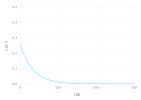

In [20]:
visualize(Growth2, :t, :r;
    stop = 300u"d",
    kind = :line,
    ylim = (0, 0.5),
)

이러한 성장률의 감소는 변환효율(`Y`)에 의한 것이 아닙니다.

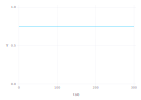

In [21]:
visualize(Growth2, :t, :Y;
    stop = 300u"d",
    kind = :line,
)

단위 생체량 기준 광합성(`A`)과 호흡(`R`)량을 그려보면 이전과 달리 시간에 따라 감소하는 것을 확인할 수 있습니다.

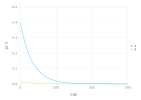

In [22]:
visualize(Growth2, :t, [:A, :R];
    stop = 300u"d",
    kind = :line,
    ylim = (0, 0.5),
)

사실 위의 두가지 접근 방식은 수식에서 값을 어떤 위치에서 곱해주는지의 차이일뿐이며 그 결과 정리된 수식은 동일합니다. 하지만 각 변수가 어떤 의미를 가지고 어떤 기작에 의해 설명되는지 분명한 차이가 있을 수 있다는 점은 기억해주세요. 잘 정의된 모형은 이후 수정하거나 확장하기에도 수월합니다.

### 2.2.4. 분배 (partitioning)

위의 모형에서는 식물의 성장이 전체 생체량에 비례해서 이루어진다고 가정하였지만, 실제로는 잎에서 생성된 동화산물이 다른 부위에 얼마만큼씩 분배되어 사용되는지에 따라 실제 관측되는 성장의 형태는 크게 달라질 수 있습니다. 특히 동화산물은 잎의 광합성에 의해 생성되므로 잎이 전체 식물에서 차지하는 비중에 따라 그 생산량도 달라질 것입니다. 그리고 성장 단계에 따라 영양성장(vegetative growth) 시기에는 많은 부분이 잎으로 할당되다가 생식성장(reproductive growth) 단계에서는 그 비중이 열매 쪽으로 옮겨가는 등의 변화도 고려해볼 수 있습니다.

여기에서는 [Monsi (1960)](https://www.cabdirect.org/cabdirect/abstract/19600600113)의 모형을 참고하여 식물의 전체 생체량을 광합성이 가능한 부위와 아닌 부위로 나누어 광합성과 호흡의 비중을 조정해보도록 하겠습니다.

$$
r = c \cdot (m A - n R)
$$

| 이름 &nbsp;&nbsp;&nbsp;&nbsp; | 값 | 단위 | 설명 |
| :- | :- | :- | :- |
| $m$ | 0.5 | - | 광합성을 하는 생체량의 비중 |
| $n$ | $$1 - m$$ | - | 광합성을 하지 않는 생체량의 비중 |

전체 생체량에서 광합성이 가능한(photosynthetic) 부분의 비중(`m`)과 그렇지 않은(non-photosynthetic) 부분의 비중(`n`)을 모수로 추가하고 각각 광합성(`A`)과 호흡(`R`)에 적용합니다.

In [23]:
@system Growth3(Growth2, Controller) begin
    m:            leaf_fraction            => 0.5           ~ preserve(parameter)
    n(m):         non_leaf_fraction        => #= .. =#      ~ track

    mA(m, A):     actual_assimilation_rate => m * A         ~ track(u"g/g/d")
    nR(n, R):     actual_respiration_rate  => n * R         ~ track(u"g/g/d")

    r(c, mA, nR): growth_rate              => #= .. =#      ~ track(u"g/g/d")
end

Growth3

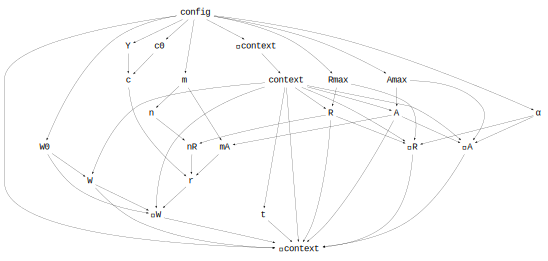

In [24]:
Cropbox.dependency(Growth3)

이제 실제 광합성이 가능한 부분만을 통해 동화산물이 생성되기 때문에 전체 생체량(`W`)도 그에 맞춰 감소하였습니다. 소폭의 비중 변화에 따라 생체량이 크게 변화하는 것을 확인할 수 있습니다.

In [25]:
manipulate(Growth3, :t, :W;
    parameters = :0 => (;
        :m => 0:0.1:1,
    ),
    stop = 300u"d",
    kind = :line,
    ylim = (0, 300),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["0"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["m"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 11, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
6, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000174a89aa0, Task (runnable) @0x0000000174a89aa0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

이러한 분배 비율의 변화가 성장률(`r`)에는 어떠한 영향을 미치는지 보도록 하겠습니다.

In [26]:
manipulate(Growth3, :t, [:mA, :nR, :r];
    parameters = :0 => (;
        :m => 0:0.1:1,
    ),
    stop = 300u"d",
    kind = :line,
    ylim = (0, 0.4),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["0"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["m"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 11, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
6, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000016e203ec0, Task (runnable) @0x000000016e203ec0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

단순해보이지만 실제 작물 모형에서는 좀 더 상세하게 구조를 나눈 다음, 각 구조별로 특화된 기작을 부여하여 서로 간의 상호작용을 만들어내는 등 다양하게 응용이 가능합니다. 예를 들어 잎은 광합성을, 줄기는 동화산물의 저장을, 뿌리는 토양수분 흡수를 담당하도록 되어 있으면 각 부위가 전체 식물에서 어떤 비중을 갖는지에 따라 전체적인 성장의 형태가 달라질 수 있는 것입니다.

## 2.3. 광합성 (`A`) 분해

여기서는 성장률(`r`)을 분해해내가는 과정을 좀 더 진행해보겠습니다. 지금까지 만든 모형에서 광합성(`A`)은 효율 저하가 반영되기는 하였지만 그 외에는 항상 같은 값을 가지는 고정된 모수로 표현되어 있었습니다. 하지만 실제 광합성은 말그대로 빛이 있어야만 일어날 수 있는 생화학 반응이며, 이외에도 대기중 이산화탄소($\mathrm{CO_2}$) 농도, 온도, 습도 등 환경 요인에 큰 영향을 받는 기작입니다. 내부적으로는 잎의 영양상태나 수분함량 등에 따라 그 효율이 변화하기도 합니다. 여기서는 우선 광량(irradiance)에 따라 변화하는 광합성율을 표현해보겠습니다.

$$
\begin{align}
A_g &= \frac{\alpha I A_{\mathrm{max}}}{\alpha I + A_{\mathrm{max}}} \\
A_n &= A_g - R_d
\end{align}
$$

| 이름 | 값 | 단위 | 설명 |
|:-------|:------|:------|:------------|
| $\alpha$ | 0.05 | $$\mathrm{\mu mol_{CO_2}}\ \mathrm{\mu mol_{photon}^{-1}}$$ | 광화학적 효율 (양자 수율; quantum yield) |
| $$A_{\mathrm{max}}$$ | 25.0 | $\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | 현재 대기 $\mathrm{[CO_2]}$와 표준 기온(25 $\mathrm{^{\circ}C}$) 기준 광포화 총광합성율 ($A_g$) |
| $R_d$ | 1.0 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | 표준 온도(25 $\mathrm{^{\circ}C}$) 기준 엽 세포호흡율 (dark respiration) |
| $I$ | - | $\mathrm{\mu mol_{photon}}\ \mathrm{m^{-2}}$ | 엽 표면에 도달하는 PAR (photosynthetically active radiation) |
| $A_g$ | - | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | 엽 $\mathrm{CO_2}$ 총동화율 (총광합성율; gross photosynthesis rate) |
| $A_n$ | - | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | 엽 $\mathrm{CO_2}$ 순동화율 (순광합성율; net photosynthesis rate) |

총광합성율($A_g$)은 광량($I$)이 증가함에 따라 함께 증가하는 직각쌍곡선(rectangular hyperbola)의 형태로 정의합니다. 광량이 많아질수록 그 증가량은 줄어들고 광포화 상태가 되어 최대값($A_max$)에 근접하게 됩니다. 순광합성율($A_n$)은 총광합성율($A_g$)에서 세포호흡율($R_d$) 제외한 값입니다. 실제 광합성은 광량 외에도 다른 요인에 영향을 받고, 세포호흡 역시 엽온에 따라 변할 수 있지만 여기서는 편의상 다른 요인들은 고정되어 있다고 가정하겠습니다.

In [27]:
@system Photosynthesis(Controller) begin
    α:    photochemical_efficiency       => 0.05                      ~ preserve(parameter)
    Amax: maximum_photosynthetic_rate    => 25                        ~ preserve(parameter, u"μmol/m^2/s")
    Rd:   dark_respiration               => 1.0                       ~ preserve(parameter, u"μmol/m^2/s")

    I:    irradiance                     => 0                         ~ preserve(parameter, u"μmol/m^2/s")

    Ag(#= .. =#):   gross_photosynthesis => #= .. =#                  ~ track(u"μmol/m^2/s")
    An(Ag, Rd):     net_photosynthesis   => Ag - Rd                   ~ track(u"μmol/m^2/s")
end

Photosynthesis

일단 특정 광량(`I`)에 대한 순광합성율(`An`)이 제대로 계산되는지 확인해보겠습니다.

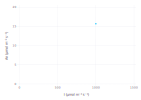

In [28]:
visualize(Photosynthesis, :I, :An;
    config = :0 => :I => 1000,
    xlim = (0, 1500),
    ylim = (0, 20),
)

그럼 이제는 한 점이 아니라 일정 범위 내의 광량(`I`)에 대해 다수의 모의를 진행하여 그 결과를 한꺼번에 표출해보도록 하겠습니다. `visualize()` 함수의 `xstep` 옵션을 사용하면 내부적으로 여러 개의 설정(configuration)을 만들어 모의를 진행한 후 결과를 합쳐서 볼 수 있습니다.

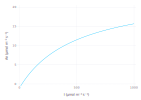

In [29]:
visualize(Photosynthesis, :I, :An;
    xstep = :0 => :I => 0:1000,
    kind = :line,
    ylim = (0, 20),
)

일단 결과적으로는 실제 광합성 측정 기기로 얻을 수 있는 광반응 곡선과 유사한 형태를 보여주고 있습니다. 하지만 앞에서 언급되었던 것처럼 다른 환경 요인에 대한 고려 없이 대략적인 곡선의 형태를 맞추어 본 것에 그치고 있다는 한계가 있습니다.

## 2.4. 기체교환 모형 (coupled gas-exchange model)

목적에 따라 다르겠지만, 기후 변화와 같이 기존에 알려지지 않은 환경에 대한 실험을 진행해야 한다면 다양한 요인의 상호작용에 대한 응답을 줄 수 있는 모형을 선택하는 것이 타당할 것입니다. 이런 측면에서 광합성의 주요 기작들을 생화학적으로 설명하고, 기공전도도(stomatal conductance)와의 연계를 통한 증산(transpiration), 이러한 과정에서 이루어지는 엽온(leaf temperature)의 에너지 균형(energy balance)까지 표현하는 기체교환 모형(gas-exchange model)은 작물모형을 비롯한 여러 분야에서 응용이 가능합니다.

Cropbox로 구현한 기체교환 모형은 지난 시간에 보았던 [마늘 모형](https://github.com/cropbox/Garlic.jl)에서 내부적으로 활용중이며, [LeafGasExchange.jl](https://github.com/cropbox/LeafGasExchange.jl)이라는 이름의 별도 Julia 패키지로 배포되고 있기도 합니다. 여기서는 후자의 패키지를 통해 모형을 사용해보는 실습을 진행하도록 하겠습니다.

In [30]:
using LeafGasExchange

LeafGasExchange 모듈은 광합성의 종류에 따라 C3, C4, 그리고 기공전도도 모형의 종류에 따라 Ball-Berry, Medlyn, 각 두가지씩 구현이 되어 있으며 이를 합쳐서 `ModelC3BB`, `ModelC3MD`, `ModelC4BB`, `ModelC4MD`와 같이 바로 사용할 수 있는 4개의 시스템을 제공하고 있습니다. 실습에서는 C3 광합성에 Ball-Berry 모형이 결합된 `ModelC3BB`를 사용하겠습니다.

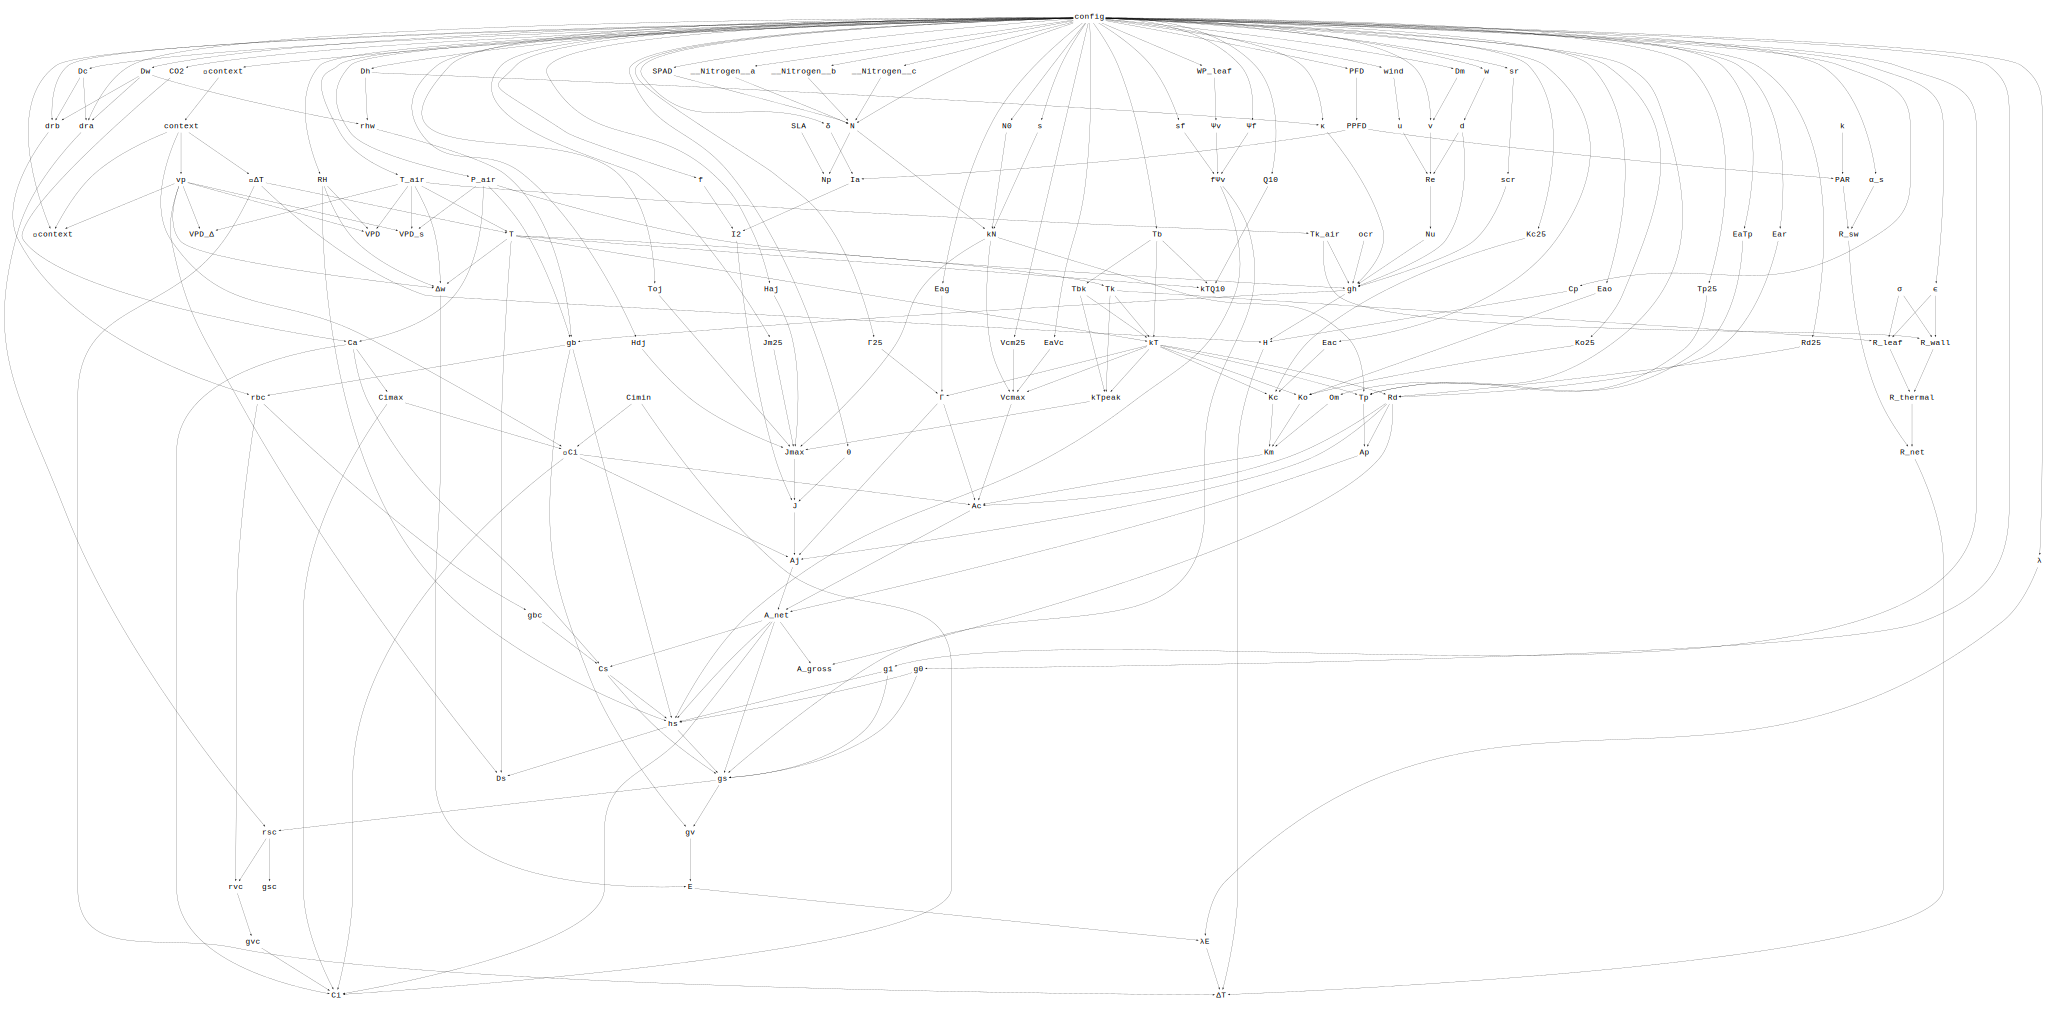

In [31]:
Cropbox.dependency(LeafGasExchange.ModelC3BB)

의존관계도(dependency graph)를 살펴보면 지금까지 다루었던 모형과는 달리 굉장히 많은 변수들이 포함되어 있는 것을 알 수 있습니다. 하지만 결국 확인하고 싶은 것은 앞의 간단한 광합성 모형과 마찬가지로 총광합성율($A_g$) 혹은 순광합성율($A_n$)과 같은 값일 것입니다. 여기서 순광합성율(`A_n`)은 아래와 같이 구현되어 있습니다.

In [32]:
@look LeafGasExchange.ModelC3BB.A_net

[doc]

[code]
  A_net(Ac, Aj, Ap):net_photosynthesis => begin
            #= /Users/tomyun/.julia/packages/LeafGasExchange/I1nMc/src/c3.jl:92 =#
            min(Ac, Aj, Ap)
        end ~ track(u"μmol/m^2/s")

C3 광합성의 주요한 제한 요인들, 즉 이산화탄소($\mathrm{CO_2}$ 혹은 RuBisCo 효소와 같은 기질의 부족(carboxylation-limited)인지, 아니면 전자전달계의 부하로 인한 제한(RuBP-renegeration limited)인지, 혹은 최종 산물의 수송이 저하되어 발생하는 제한(triose phosphate utilization-limited)인지에 따라 각각의 잠재 광합성율(`Ac`, `Aj`, `Ap`)이 계산되고 그중에서 가장 제한이 많이 걸리는 쪽, 다시 말해 최소값이 최종 광합성율로 채택됩니다.

기질 부족으로 인한 광합성율(`Ac`)은 대개 이산화탄소 분압이 낮은 단계에서 발생하는데, 이러한 생화학적 기작은 앞서 보았던 광량에 따른 광합성율 수식과 유사한 쌍곡선의 형태로 구현되고 있습니다.

In [33]:
@look LeafGasExchange.ModelC3BB.Ac

[doc]

[code]
  Ac(Vcmax, Ci, Γ, Km, Rd):enzyme_limited_photosynthesis_rate => begin
            #= /Users/tomyun/.julia/packages/LeafGasExchange/I1nMc/src/c3.jl:79 =#
            (Vcmax * (Ci - Γ)) / (Ci + Km) - Rd
        end ~ track(u"μmol/m^2/s")

단, 각각의 모수 혹은 모수처럼 보이지만 사실은 또 다른 수식으로 표현되는 변수들이 워낙 많기 때문에 한눈에 모든 것을 파악하기는 쉽지 않습니다. 예를 들어 위에서 쓰인 `Vcmax`는 이산화탄소를 기질로 하는 RuBisCo 효소의 최대 반응속도이며, 앞의 `Amax`처럼 고정된 상수를 도입할 수도 있는 부분입니다. 하지만 온도에 따른 생화학 반응의 차이를 반영하기 위해 내부적으로는 [아레니우스 방정식(Arrhenius equation)](https://en.wikipedia.org/wiki/Arrhenius_equation)에 대입하여 계산하도록 되어 있습니다.

In [34]:
@look LeafGasExchange.ModelC3BB.Vcmax

[doc]

[code]
  Vcmax(Vcm25, kT, EaVc, kN):maximum_carboxylation_rate => begin
            #= /Users/tomyun/.julia/packages/LeafGasExchange/I1nMc/src/c3.jl:30 =#
            Vcm25 * kT(EaVc) * kN
        end ~ track(u"μmol/m^2/s")

이처럼 많은 변수들을 한곳에서 모두 정리하기에는 너무 복잡하기 때문에 실제 모형 명세는 관련된 변수들끼리 묶인 시스템 단위로 잘개 쪼개져 있습니다. 이러한 시스템간의 구조도는 `Cropbox.hierarchy()` 함수를 이용해 확인할 수 있습니다.

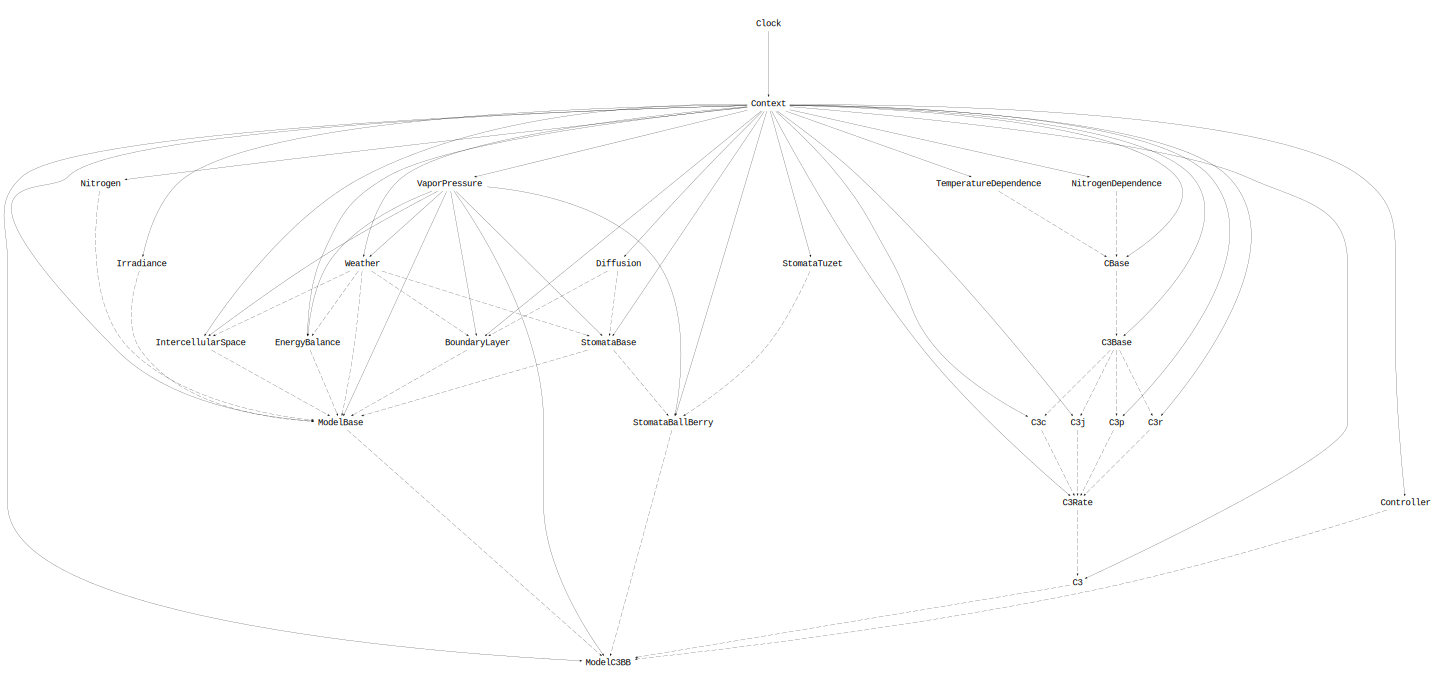

In [35]:
Cropbox.hierarchy(LeafGasExchange.ModelC3BB)

우측에는 방금 살펴보았던 C3 광합성 관련 시스템들이 보입니다. 제한 요인의 종류에 따라 `C3c`, `C3j`, `C3p`와 같이 서로 다른 시스템이 정의되어 있는 것을 알 수 있습니다. 좌측에는 기공전도도(`StomataBallBerry`) 및 에너지 균형(`EnergyBalance`) 관련 시스템들이 보입니다. 이러한 시스템들은 몇몇 공통되는 변수들을 이용해 정의되어 있으며, 최종적으로는 이러한 시스템들이 모두 묶여 해당 변수들이 서로 공유되는 형태로 통합(coupling)이 이루어지게 됩니다. 참고로, 지난 시간 강의자료의 마지막에 나오는 내부구조 안내에서 설명하는 믹스인(mix-in)을 통한 확장의 예라고 보시면 되겠습니다.

하지만 이렇게 모형이 어떻게 만들어져 있는지에 대한 기술적인 부분은 모형을 불러서 사용하는 입장에서는 크게 중요하지 않은 부분일 수도 있습니다. 위에서 굉장히 복잡한 모형의 일면을 보여드렸지만, 실제 사용하는 방법은 앞서 다루었던 간단한 모형들과 크게 다를 바 없기 때문입니다.

먼저 필요한 모수들을 살펴보겠습니다.

In [36]:
parameters(LeafGasExchange.ModelC3BB)

Config for 1 system:
  ModelC3BB
    PFD           = nothing
    CO2           = nothing
    RH            = nothing
    T_air         = nothing
    wind          = nothing
    P_air         = 100 kPa
    SPAD          = 60
    (Nitrogen) _a = 0.0004 g m⁻²
    (Nitrogen) _b = 0.012 g m⁻²
    (Nitrogen) _c = 0 g m⁻²
    N             = missing
    Dw            = 24.2 mm² s⁻¹
    Dc            = 14.7 mm² s⁻¹
    Dh            = 21.5 mm² s⁻¹
    Dm            = 15.1 mm² s⁻¹
    w             = 10 cm
    sr            = 1.0
    v             = missing
    κ             = missing
    g0            = 0.017 mol bar⁻¹ m⁻² s⁻¹
    g1            = 4.53
    drb           = missing
    dra           = missing
    δ             = 0.15
    f             = 0.15
    ϵ             = 0.97
    λ             = 44 kJ mol⁻¹
    Cp            = 29.3 J K⁻¹ mol⁻¹
    α_s           = 0.5
    WP_leaf       = 0 MPa
    Ψf            = -2.0 MPa
    sf            = 2.3 MPa⁻¹
    Tb            = 25 °C
    Q10      

광량(`PFD`)이나 기온(`T_air`) 등 환경 조건에 대한 모수들은 기본값이 없으므로 별도의 설정을 만들어서 넣어주도록 하겠습니다.

In [37]:
ge_config = @config :Weather => (
    PFD = 1500,
    CO2 = 400,
    RH = 60,
    T_air = 30,
    wind = 2.0,
)

Config for 1 system:
  Weather
    PFD   = 1500
    CO2   = 400
    RH    = 60
    T_air = 30
    wind  = 2.0

이제 다른 모형과 동일한 방식으로 `visualize()` 함수를 이용하여 그래프를 그릴 수 있습니다. 예를 들어 세포내 이산화탄소 분압(intercellular $[\mathrm{CO_2}]$; $C_i$)에 따른 순광합성율(`A_net`)을 각 제한 요인에 따른 잠재 광합성율(`Ac`, `Aj`, `Ap`)과 함께 확인해보겠습니다. 보통 A-Ci 곡선이라고 부르기도 합니다.

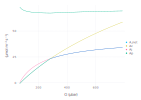

In [38]:
visualize(LeafGasExchange.ModelC3BB, :Ci, [:A_net, :Ac, :Aj, :Ap];
    config = ge_config,
    xstep = :Weather => :CO2 => 10:10:1500,
    kind = :line,
)

아래에는 다양한 환경 요인들을 직접 조정하여 광합성 곡선을 그려볼 수 있도록 준비해보았습니다.

### A-Ci

세포내 이산화탄소 분압(`Ci`)은 대기중 이산화탄소가 엽록체(chloroplast)가 있는 위치까지 확산(diffusion)되어 광합성이 이루어지며 정상상태(steady-state)에 이르렀을 때 결정되는 값입니다. 이에 따라 대기중 이산화탄소 농도(`CO2`)보다는 낮은 값을 갖는 것이 보통입니다.

In [39]:
manipulate(LeafGasExchange.ModelC3BB, :Ci, [:A_net, :Ac, :Aj, :Ap],
    config = ge_config,
    parameters = :Weather => (;
        PFD   = 0:20:2000,
        T_air = -10:1:50,
    ),
    xstep = :Weather => :CO2 => 10:10:1500,
    xlim = (0, 800),
    ylim = (0, 60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["PFD"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
76, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000174b54780, Task (runnable) @0x0000000174b54780), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                c

### A-Q

광량(`PFD`)은 전자전달계의 제한으로 인한 잠재 광합성율(`Aj`)과 직접적인 연관을 가집니다. 어떤 상황에서 이러한 제한이 두드러지게 되는지 다양한 조건들을 실험해보세요.

In [40]:
manipulate(LeafGasExchange.ModelC3BB, :PFD, [:A_net, :Ac, :Aj, :Ap],
    config = ge_config,
    parameters = :Weather => (;
        CO2   = 10:10:1500,
        T_air = -10:1:50,
    ),
    xstep = :Weather => :PFD => 0:20:2000,
    ylim = (0, 60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 150, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
40, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000178bbeba0, Task (runnable) @0x0000000178bbeba0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                c

### A-T

엽온(`T`)은 기온(`T_air`)을 바탕으로 에너지 균형을 고려하여 계산됩니다. 이에 따라 광량(`PFD`)이 많아지면 복사열에 의한 엽온 상승 효과로 인해 전체적인 곡선이 옆으로 조금씩 이동하는 것을 볼 수 있습니다.

In [41]:
manipulate(LeafGasExchange.ModelC3BB, :T, [:A_net, :Ac, :Aj, :Ap],
    config = ge_config,
    parameters = :Weather => (;
        CO2   = 10:10:1500,
        PFD   = 0:20:2000,
    ),
    xstep = :Weather => :T_air => -10:1:50,
    xlim = (-10, 50),
    ylim = (0, 60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 150, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
40, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000178bbbca0, Task (runnable) @0x0000000178bbbca0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                c

### N vs. Ψv

엽내 질소(`N`) 및 수분(`Ψv`) 함량 간의 상호작용을 고려하며 환경 요인의 변화에 따른 광합성을 살펴볼 수 있는 등고선(contour) 그래프입니다. 환경 조건에 따라 질소 및 수분 함량의 영향력이 상대적으로 바뀔 수 있다는 것을 확인할 수 있습니다.

In [42]:
manipulate(LeafGasExchange.ModelC3BB, :N, :Ψv, :A_net;
    config = ge_config,
    parameters = :Weather => (;
        CO2   = 10:10:1500,
        PFD   = 0:20:2000,
        T_air = -10:1:50,
    ),
    xstep = :Nitrogen     => :N       => 0.4:0.2:2,
    ystep = :StomataTuzet => :WP_leaf => -2:0.2:0,
    xlim = (0.4, 2),
    zlim = (0, 30),
    zgap = 1,
    kind = :contour,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 150, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
40, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/Users/tomyun/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/Users/tomyun/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000017a063750, Task (runnable) @0x000000017a063750), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                c

## 2.5. 차회예고

지난 주 첫시간부터 간단한 성장곡선에서 시작하여 모형을 조금씩 분해해가며 기작을 추가해본 끝에 기체교환 모형까지 살펴보았습니다. 상대적으로 훨씬 복잡한 모형이지만 결국은 성장률(`r`)을 결정하는 주요 요인인 광합성율(`A`)을 계산하는 여러가지 방법 중의 하나라는 관점에서 보면 모두 같은 선상에 놓여있다고 생각합니다. 모형을 만드는 목적에 따라 필요한 기작을 더 넣어보거나, 바꾸거나 혹은 없애는 과정을 점진적으로 반복하는 것, 그것이 모형개발(modeling)의 핵심이라고 볼 수 있겠습니다. 비록 지금까지 2회에 걸쳐 작물모형의 일부만을 다루었지만 전체적으로는 유사한 과정의 확장이라는 점 기억해주세요. 다음 시간에는 작물모형의 중추라고 볼 수 있는 생물계절(phenology)에 대해 살펴보겠습니다. GDD(growing degree days)와 같은 열시간(thermal time) 개념을 구현하면서 실제 자료를 적용해보는 실습을 진행할 예정입니다.